In [ ]:
# Imports for loading and preprocessing the data
import random
import numpy as np
import pandas as pd
from tqdm import tqdm  # show progress bar
from nltk.tokenize import TweetTokenizer

# TensorFlow 
import tensorflow as tf
# Next line only for Colab
# %tensorflow_version 2.x

# Sklearn for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Bokeh for visualization
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Title
from bokeh.transform import factor_cmap
from bokeh.palettes import Colorblind3

In [ ]:
# dataset coming from 1_Preprocessing
tweets = pd.read_pickle("path/New_Preprocessed_Dataset_GAN.pkl")
tweets = tweets[tweets['label'] == 'racism']

In [3]:
# dataframe to list of sentences
sentences = tweets['text'].tolist()
print(sentences[:5])

['wrong isis follows the example of mohammed and the quran exactly.', 'a good muslim is good despite his bad religion not because of it.', 'yeah its called caring about human life idiot something a genocidal isis would not understand.', 'you are a muslim. you are brain dead. you repeat what others have said a million times.', 'if you want to understand the lie of muslims living in peace with jews read ibn warraq']


In [ ]:
# Apply nltk's tweettokenizer
tweets_tokenized = [TweetTokenizer(preserve_case=False).tokenize(tweet) for tweet in sentences]

In [ ]:
from gensim.models import KeyedVectors
from collections import defaultdict

# 1. load full GloVe
glove_path = "path/glove.6B.200d.txt"
glove = KeyedVectors.load_word2vec_format(glove_path, no_header=True)

# 2. detect singletons
word_counts = defaultdict(int)
for tweet in tweets_tokenized:
    for word in tweet:
        word_counts[word] += 1

singletons = {word for word, count in word_counts.items() if count == 1}

# 3. check if singletons are in GloVe
missing_singletons = {word for word in singletons if word not in glove}

# 4. filter tweets to remove those containing missing singletons
filtered_tweets = [
    tweet for tweet in tweets_tokenized
    if not any(word in missing_singletons for word in tweet)
]

print(f"Phrases initiales: {len(tweets_tokenized)}")
print(f"Phrases filtrées: {len(filtered_tweets)}")
print(f"Phrases supprimées: {len(tweets_tokenized) - len(filtered_tweets)}")
print(f"Singletons problématiques: {len(missing_singletons)}")

Phrases initiales: 1965
Phrases filtrées: 1822
Phrases supprimées: 143
Singletons problématiques: 167


In [6]:
tweets_tokenized = filtered_tweets

In [7]:
# Set a seed to make results comparable
random.seed(69)
# Shuffle the dataset once, to obtain random train and test partitions later
random.shuffle(tweets_tokenized)

# Add start and end of sequence token to every tweet
# and create the two datasets
train_data = []
word2vec_data = []

for tweet in tweets_tokenized:
  tweet.insert(len(tweet), "<End>")
  tweet.insert(0, "<Start>")
  train_data.append((tweet, tweet[1:], tweet[:-1]))
  word2vec_data.append(tweet)

In [8]:
max_length = 0
idx = 0
for tweet in tweets_tokenized:
  if len(tweet) > max_length:
    max_length = len(tweet)

print(f"Longest Tweet has {max_length} tokens.")

Longest Tweet has 35 tokens.


In [9]:
all_tokens = set(token for tweet in tweets_tokenized for token in tweet)

In [ ]:
def load_glove_subset(glove_file_path, allowed_tokens):
    glove_model = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            if word in allowed_tokens:
                embedding = np.array(split_line[1:], dtype=np.float64)
                glove_model[word] = embedding
    return glove_model

glove_subset = load_glove_subset("path/glove.6B.200d.txt", all_tokens)

In [ ]:
# initialize a KeyedVectors model with the correct vector size
model = KeyedVectors(vector_size=200)

# add the loaded GloVe vectors to the model
for token, vector in glove_subset.items():
    model.add_vector(token, vector)

print(f"Vocab size of our glove model : {len(model.key_to_index)} / total vocab : {len(all_tokens)}")

# list to keep track of missing tokens
missing_tokens = []

# Add missing tokens with random vectors (such as the <Start>, <End>, and <user> tokens)
for tweet in tweets_tokenized:
    for token in tweet:
        if token not in model.key_to_index:
            model.add_vector(token, np.random.normal(scale=0.6, size=(model.vector_size,)))
            missing_tokens.append(token)

# display missing tokens
print(f"\n{len(missing_tokens)} missing tokens added with random vectors:\n")
print(sorted(set(missing_tokens)))

In [12]:
embedding_matrix = np.zeros((len(model.key_to_index), 200))
for i in range(len(model.key_to_index)):
    embedding_vector = model[model.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Add a single row to shift the matrix to the right (since later we use 0 padding for our batches)
embedding_matrix = np.insert(arr=embedding_matrix, obj=0, values=np.zeros(200), axis=0)

embedding_matrix.shape

(3405, 200)

In [13]:
vocab_size = len(model.key_to_index)
print(f"Vocab size of our word2vec model: {vocab_size}")

Vocab size of our word2vec model: 3404


In [ ]:
# create a word2index dictionary and an embedding matrix
word2index_dict = {}
embedding_matrix = [np.zeros(200)]  

for i, token in enumerate(model.key_to_index): 
    word2index_dict[token] = i + 1               # +1 car 0 = padding
    embedding_matrix.append(model[token])       

embedding_matrix = np.array(embedding_matrix)

tweets2index_input = []
tweets2index_target = []
tweets2index_teacher_forcing = []

for input_seq, target_seq, teacher_seq in train_data:
    input = [word2index_dict[key] for key in input_seq]
    target = [word2index_dict[key] for key in target_seq]
    teacher = [word2index_dict[key] for key in teacher_seq]

    tweets2index_input.append(input)
    tweets2index_target.append(target)
    tweets2index_teacher_forcing.append(teacher)

In [15]:
print(tweets2index_input[0])
print(tweets2index_teacher_forcing[0])
print(tweets2index_target[0])

[3400, 856, 3, 6, 82, 4, 85, 29, 21, 122, 119, 597, 3, 6, 38, 3166, 1039, 38, 670, 1825, 20, 2335, 3, 3401]
[3400, 856, 3, 6, 82, 4, 85, 29, 21, 122, 119, 597, 3, 6, 38, 3166, 1039, 38, 670, 1825, 20, 2335, 3]
[856, 3, 6, 82, 4, 85, 29, 21, 122, 119, 597, 3, 6, 38, 3166, 1039, 38, 670, 1825, 20, 2335, 3, 3401]


In [ ]:
train_split = 0.9  # 90 train / 10 test was best for our model

batch_size = 32

train_size = int(len(tweets2index_input) * train_split)

# training data
train_ragged_dataset_input = tf.ragged.constant(tweets2index_input[:train_size])
train_ragged_dataset_target = tf.ragged.constant(tweets2index_target[:train_size])
train_ragged_dataset_teacher = tf.ragged.constant(tweets2index_teacher_forcing[:train_size])

train_dataset_input = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_input)
train_dataset_target = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_target)
train_dataset_teacher = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_teacher)

train_dataset_input = train_dataset_input.map(lambda x: x)
train_dataset_target = train_dataset_target.map(lambda x: x)
train_dataset_teacher = train_dataset_teacher.map(lambda x: x)

# training dataset
train_dataset = tf.data.Dataset.zip((train_dataset_input, train_dataset_target, train_dataset_teacher))

train_dataset = (train_dataset
                .cache()
                .shuffle(buffer_size=10000, reshuffle_each_iteration=True)  # Buffer plus grand
                .padded_batch(batch_size)  # Batch plus petit
                .prefetch(tf.data.experimental.AUTOTUNE))

# test data
test_ragged_dataset_input = tf.ragged.constant(tweets2index_input[train_size:])
test_ragged_dataset_target = tf.ragged.constant(tweets2index_target[train_size:])
test_ragged_dataset_teacher = tf.ragged.constant(tweets2index_teacher_forcing[train_size:])

test_dataset_input = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_input)
test_dataset_target = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_target)
test_dataset_teacher = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_teacher)

test_dataset_input = test_dataset_input.map(lambda x: x)
test_dataset_target = test_dataset_target.map(lambda x: x)
test_dataset_teacher = test_dataset_teacher.map(lambda x: x)

# test dataset
test_dataset = (tf.data.Dataset.zip((test_dataset_input, test_dataset_target, test_dataset_teacher))
                .cache()
                .padded_batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
import sys
sys.path.append('path/Modules/racism')

import racism_ae as ae
import racism_ae_training as ae_training

In [18]:
TwitterAE = ae.AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)

In [ ]:
# Train the model

ae_training.trainModel(model=TwitterAE, word2vec_model=model, train_dataset=train_dataset, test_dataset=test_dataset, loss_function=tf.keras.losses.SparseCategoricalCrossentropy(), num_epochs=150, early_stopping_patience=100, lr_reduce_factor=0.95)

In [ ]:
# if you want to load weights from a previous training

sequence_length = 200
dummy_input = np.random.randint(0, vocab_size, (1, sequence_length))
dummy_teacher = np.random.randint(0, vocab_size, (1, sequence_length))

# Dummy pass to build the model (initialize weights)
_ = TwitterAE(dummy_input, dummy_teacher, training=False)

In [ ]:
TwitterAE.load_weights("path/AE_Weights/racism_ae_weights.weights.h5")

In [21]:
TwitterAE.summary()

Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │       862,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     4,649,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,512,005 (21.03 MB)

 Trainable params: 4,150,005 (15.83 MB)

 Non-trainable params: 1,362,000 (5.20 MB)

In [ ]:
# test of inference mode
test_sentence = "islam is not a religion of peace"
tokens = TweetTokenizer(preserve_case=False).tokenize(test_sentence)
tokens = ["<Start>"] + tokens + ["<End>"]

indices = [word2index_dict.get(tok, 0) for tok in tokens] 

input_tensor = tf.constant([indices])  # batch size 1
latent = TwitterAE.Encoder(input_tensor, training=False)

decoded_indices = TwitterAE.Decoder.inference_mode(states=latent, training=False)

decoded_tokens = [model.index_to_key[i.numpy()[0] - 1] for i in decoded_indices if i.numpy()[0] != 0]
print(" ".join(decoded_tokens))

islam is a religion of hate . <End>


### Gan

In [23]:
train_dataset_GAN = train_dataset_input
train_dataset_GAN = train_dataset_input.map(lambda x: tf.squeeze(TwitterAE.Encoder(tf.expand_dims(x, axis=0)), axis=0))
train_dataset_GAN = train_dataset_GAN.cache().batch(50).prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
import racism_latextgan as latextgan
import racism_latextgan_training as latextgan_training

In [ ]:
# Initialize your models
LaTextGAN_Generator = latextgan.Generator() 
LaTextGAN_Discriminator = latextgan.Discriminator() 


From Fixed Vector: and muslims are expected to fear their religion by islam . but we are always about islam than . <End>
From Fixed Vector: islam is a strong supporter of murdering non muslims . isis is a strong supporter of non <End>

From Random Vector: islam is a pile of hatred murder bigotry sexism and sexism is islam . <End>
From Random Vector: islam is a pile of manure for murder unbelievers . isis does your prophet ! . <End>


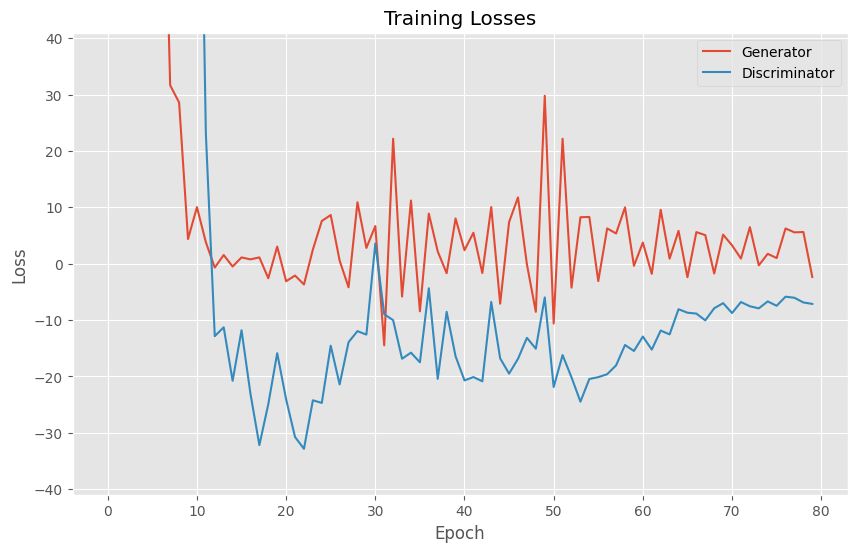

Time: 3.23s


In [ ]:
# Create the trainer instance
trainer = latextgan_training.GANTrainer(
    generator=LaTextGAN_Generator,
    discriminator=LaTextGAN_Discriminator,
    autoencoder=TwitterAE,
    word2vec_model=model
)

# Train the model
trainer.train(
    dataset=train_dataset_GAN,
    epochs=80, 
    lr=0.0001, # learning rate
    d_steps=3  # Number of discriminator steps per generator step
)

In [27]:
import racism_latextgan_evaluation as eval

Loading BokehJS ...

In [28]:
eval.tweet_generator(generator=LaTextGAN_Generator, autoencoder=TwitterAE, word2vec_model=model, num_tweets=50)


islam is a pile of manure for murder unbelievers . it has zero room for propaganda . <End>

islam is a pile of hatred murder bigotry sexism . islam is a cult . <End>

isis practices slavery and rape mohamed practiced slavery and rape . <End>

and if someone risks the world to be an excuse . islam is not a race and incitement and murder . <End>

islam is a pile of manure . if you cannot win for a country on the world . <End>

and the quran is full of hatred and murder hatred and bigotry . <End>

islam is a strong supporter of murdering non muslims . isis is a threat . <End>

islam is a pile of hatred murder bigotry sexism . islam is a cult . <End>

islam is a pile of manure . if you cannot win <num> on the barbarity of islam . <End>

and muslims are expected to fear their religion . but is not accepted in islam . it is a disgusting of hate <End>

isis beheads people because mohammed beheaded <num> jews in one day . <End>

islam is a pile of hatred murder bigotry sexism and sexism is is

In [29]:
eval.bleu4_score(generator=LaTextGAN_Generator, autoencoder=TwitterAE, word2vec_model=model, reference_data=train_data, num_tweets=500)

0.7231097589413225

In [ ]:
#LaTextGAN_Generator.save_weights(f"path/racism_LaTextGAN.weights.h5")

In [ ]:
latent_dim = 100
# dummy input for the generator
dummy_input = tf.random.normal((1, latent_dim))
_ = LaTextGAN_Generator(dummy_input, training=False)

# load weights
LaTextGAN_Generator.load_weights("path/GAN_Weights/racism_LaTextGAN.weights.h5")

In [32]:
eval.tweet_generator(generator=LaTextGAN_Generator, autoencoder=TwitterAE, word2vec_model=model, num_tweets=5)


and if someone risks the world knows that the muslims have been exterminating jews and christians in their prophet . <End>

islam is a strong supporter of murdering non muslims . isis is a strong supporter of non . <End>

and if someone risks the world to save them to stay a mass grave and then will be a muslim . <End>

and if someone risks the world knows that the muslims have been exterminating jews and christians in their . <End>

islam is a pile of manure for human human . human through violence against minorities . <End>


Average length of generated tweets: 19.8 tokens



In [ ]:
def tweet_generator(generator, autoencoder, model, target_num: int = 1500, label: str = None, oversampling_factor: int = 10):
    """
    Generate a target number of unique synthetic tweets using a GAN and Autoencoder.

    Args:
        generator (tf.keras.Model): The trained generator model.
        autoencoder (object): Autoencoder with a Decoder.inference_mode method.
        model (gensim KeyedVectors): Pretrained word2vec model (for index_to_key).
        target_num (int): Number of unique tweets to generate.
        label (str, optional): Label to assign to the generated tweets.
        oversampling_factor (int): How much to oversample at each iteration to reach uniqueness.

    Returns:
        pd.DataFrame: DataFrame with columns ['text'] or ['text', 'label'].
    """
    unique_tweets = set()
    total_tokens = 0

    pbar = tqdm(total=target_num, desc="Collecting unique tweets")

    while len(unique_tweets) < target_num:
        num_to_generate = (target_num - len(unique_tweets)) * oversampling_factor
        noise = tf.random.normal([num_to_generate, 100])
        fake_states = generator(noise)

        for i in range(num_to_generate):
            decoded_indices = autoencoder.Decoder.inference_mode(states=tf.expand_dims(fake_states[i], 0), training=False)
            tokens = [model.index_to_key[i.numpy()[0] - 1] for i in decoded_indices if i.numpy()[0] != 0]
            tweet = ' '.join(tokens)
            if tweet not in unique_tweets:
                unique_tweets.add(tweet)
                total_tokens += len(tokens)
                pbar.update(1)
                if len(unique_tweets) == target_num:
                    break

    pbar.close()
    df = pd.DataFrame({'text': list(unique_tweets)})
    if label:
        df['label'] = label

    avg_len = total_tokens / target_num
    print(f"Generated {target_num} unique tweets. Average length: {avg_len:.2f} tokens.")

    return df

In [40]:
synthetic_df = tweet_generator(generator=LaTextGAN_Generator, autoencoder=TwitterAE, model=model, target_num=1500)

Generated 1500 unique tweets. Average length: 19.77 tokens.


In [ ]:
# It took 2h50
# print unique len of synthetic_df
print(f"Unique tweets in synthetic_df: {len(synthetic_df['text'].unique())}")

Unique tweets in synthetic_df: 1500


In [ ]:
synthetic_df.to_pickle("path/Dataset/racism_gan_tweets.pkl")

In [ ]:
def plot_tsne_only(generator, autoencoder, train_dataset: tf.data.Dataset, name: str):

    # Encode real tweets (Encoder)
    real_embeddings = [autoencoder.Encoder(tweet, training=False) for tweet, _, _ in train_dataset.take(500)]
    real_embeddings = [vec.numpy() for batch in real_embeddings for vec in batch]

    # Generate fake tweets (Generator)
    fake_embeddings = []
    for _ in range(500):
        noise = tf.random.normal([50, 100])
        fake_batch = generator(noise)
        fake_embeddings.extend(fake_batch.numpy())

    # Apply PCA
    pca = PCA(n_components=50, svd_solver="randomized", random_state=0)
    real_pca = pca.fit_transform(real_embeddings)
    fake_pca = pca.fit_transform(fake_embeddings)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30., random_state=0)
    tsne_real = tsne.fit_transform(real_pca)
    tsne_fake = tsne.fit_transform(fake_pca)

    # Merge and label
    x = np.concatenate((tsne_real[:, 0], tsne_fake[:, 0]))
    y = np.concatenate((tsne_real[:, 1], tsne_fake[:, 1]))
    labels = ["Encoder"] * len(tsne_real) + ["Generator"] * len(tsne_fake)

    # Plot
    p = figure(tools="pan,wheel_zoom,reset,save",
               toolbar_location="above",
               title="2D t-SNE Latent Embedding")
    p.title.text_font_size = "20px"
    p.add_layout(Title(text=name, text_font_size="12px"), 'above')

    source = ColumnDataSource(data=dict(x=x, y=y, label=labels))

    p.scatter(x="x", y="y", size=3, source=source,
              fill_color=factor_cmap('label', palette=Colorblind3, factors=["Encoder", "Generator"]),
              fill_alpha=0.4, line_color=None, legend_field='label')

    p.legend.location = "top_left"
    p.legend.click_policy = "hide"
    show(p)


In [ ]:
plot_tsne_only(generator=LaTextGAN_Generator, autoencoder=TwitterAE, train_dataset=train_dataset, name="LaTextGAN vs Encoder")